In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import funcs.utils as utils
import funcs.plotting as plot
import funcs.amyloid as amyloid

In [2]:
PROCESSED_DIR = "data/processed"

### 1. Load Data
---

In [3]:
# Raw Data
data_df = pd.read_csv(os.path.join(PROCESSED_DIR, "AL_with_ccp_03.tsv"), sep='\t', index_col=0).rename(columns=amyloid.ddict_unclean)

# Fix Dates
data_df = pd.concat([pd.to_datetime(data_df[amyloid.dates][var], format="mixed") for var in amyloid.dates], axis=1, keys=amyloid.dates).join(
    data_df.drop(amyloid.dates, axis=1)  
)

In [4]:
# Treatments processed
treatments_df = pd.read_csv(os.path.join(PROCESSED_DIR, "treatments_processed.tsv"), sep='\t', index_col=0)
treatments_df['Start date'] = pd.to_datetime(treatments_df['Start date'], format="mixed")
treatments_df = treatments_df.join(data_df['Date of admission to center'])

In [5]:
symptom_onsets = ['Cardiopulmonary symptom onset', 'Renal signs/symptom onset', 'Neurologic symptom onset']

for symptom_onset in symptom_onsets:
    print(symptom_onset, data_df[data_df[symptom_onset] > data_df["Date of admission to center"]].shape[0])

Cardiopulmonary symptom onset 26
Renal signs/symptom onset 23
Neurologic symptom onset 15


#### ESKD Treatment & Timing
---

In [6]:
# Load RRT dates
rrt_files = ["PeritonealDialysis.csv","Hemodialysis.csv","KidneyTransplant.csv","AddnlPD.csv"]

rrt_df = list()

# Add all modalities
for rrt in rrt_files:
    _df = pd.read_csv(os.path.join("data/raw",rrt),sep=",",index_col=0)
    _df["modality"] = "Peritoneal Dialysis" if rrt in ["PeritonealDialysis.csv","AddnlPD.csv"] else rrt.split(".csv")[0]
    rrt_df.append(_df)

rrt_df = pd.concat(rrt_df)

# Fix dates mis-entered in database
rrt_df.loc[9423, "Date performed"] = "7/27/1994"
rrt_df.loc[9665, "Date performed"] = "4/5/2003"

# Save file
rrt_df.to_csv("data/processed/rrt_dates_all.tsv", sep="\t")

# Filter for duplicate entries (ie patient has multiple RRT options, we only want first one)
rrt_filt_df = rrt_df.dropna(subset=["Date performed"]).sort_values("Date performed").reset_index().drop_duplicates(subset="Code ID").set_index("Code ID")
rrt_filt_df = pd.concat([rrt_filt_df,rrt_df.loc[np.setdiff1d(rrt_df.index,rrt_filt_df.index),:]])

In [9]:
# Create ESKD dataframe
eskd_df = data_df.join(treatments_df[treatments_df["treatment_eskd"]].reset_index()[["Code ID","treatment_eskd"]].drop_duplicates(
    subset="Code ID").set_index("Code ID"))[["treatment_eskd"]]

eskd_df["treatment_eskd"] = eskd_df["treatment_eskd"].apply(lambda x: 1 if x==True else 0)

# Join ESKD dataframe to RRT timing
eskd_df = eskd_df.join(rrt_filt_df)
eskd_df = eskd_df.drop(columns=["Date of diagnosis"]).rename(columns={"Date performed":"Date of RRT Start","End date":"Date of RRT End","modality":"RRT Type"})
eskd_df = data_df[["Date of admission to center","Date of diagnosis","Date of death","Date of last visit","time","status","time_from_admission"]].join(eskd_df)
eskd_df["Date of RRT Start"] = pd.to_datetime(eskd_df["Date of RRT Start"], format="mixed")
eskd_df["Date of RRT End"] = pd.to_datetime(eskd_df["Date of RRT End"], format="mixed")

# Get time to ESKD
eskd_df['time_to_eskd'] = eskd_df.apply(lambda row: utils.get_time_eskd(row),1)
eskd_df['time_to_eskd_from_admission'] = eskd_df.apply(lambda row: utils.get_time_eskd(row, start_time="Date of admission to center"),1)

In [10]:
eskd_df[(eskd_df['time_to_eskd_from_admission']<0) & (eskd_df['treatment_eskd']==0)]

,Date of admission to center,Date of diagnosis,Date of death,Date of last visit,time,status,time_from_admission,treatment_eskd,Date of RRT Start,Date of RRT End,Comment,RRT Type,time_to_eskd,time_to_eskd_from_admission
Code ID,,,,,,,,,,,,,,
2013168,2013-10-09,2013-07-24,NaT,2013-10-08,0.208077,0,-0.002738,0,NaT,NaT,NaN,NaN,0.208077,-0.002738
2014033,2014-02-25,2012-09-01,NaT,2014-02-24,1.481177,0,-0.002738,0,NaT,NaT,NaN,NaN,1.481177,-0.002738
2017108,2017-06-30,2017-01-13,NaT,2017-06-26,0.449008,0,-0.010951,0,NaT,NaT,NaN,NaN,0.449008,-0.010951


In [11]:
# Competing risk
eskd_df['CR_event'] = eskd_df.apply(utils.get_cr_event,axis=1)
eskd_df['CR_time'] = eskd_df.apply(utils.get_cr_time, axis=1, start_time="Date of admission to center")

In [10]:
eskd_df.to_csv("data/processed/treatment_eskd.tsv", sep="\t")

#### Hematologic Response
---

In [12]:
def assign_tx_response(x):
    if x==0:
        return "n/a"
    elif x==1:
        return "No"
    elif x==2:
        return "Yes"
    elif x==3:
        return "Relapse"
    elif x==4:
        return "n/a"
    else:
        return "n/a"

In [13]:
hr_df = pd.read_csv("data/raw/HemeCR.csv", sep=",")
hr_df["response"] = hr_df['Complete response to treatment?'].apply(lambda x: assign_tx_response(x))
hr_df['Visit date'] = pd.to_datetime(hr_df['Visit date'], format="mixed")
hr_df['If relapse, date.'] = pd.to_datetime(hr_df['If relapse, date.'], format="mixed")

# Add data
hr_df = hr_df.set_index("Code ID").join(data_df["Date of admission to center"]).join(data_df.iloc[:,-9:])

# Filter
hr_df = hr_df.dropna(subset="fna3_cluster")
hr_df = hr_df[hr_df['response']!='n/a']

In [14]:
fu_dict = dict()

for c in np.unique(hr_df.index):
    # Get slice
    d = dict()
    _df = hr_df.loc[[c],]
    _df = _df.sort_values("Visit date")
    admission = _df.iloc[0]["Date of admission to center"]

    # Follow-up time
    d['Follow-up Time'] = (_df['Visit date'].max() - _df['Visit date'].min()) / pd.Timedelta(days=365.25)
    d['No. Visits'] = _df.shape[0]

    # Time until first relapse
    if "Relapse" in _df["response"].values:
        d['first_relapse_date'] = _df.loc[_df['response']=="Relapse",["Visit date","If relapse, date."]].min(axis=1).iloc[0]
        d['time_to_relapse'] = (d['first_relapse_date'] -  admission) / pd.Timedelta(days=365.25)
        d['status_relapse'] = 1
    else:
        d['first_relapse_date'] = None
        d['time_to_relapse'] = (_df['Visit date'].max() - admission)  / pd.Timedelta(days=365.25)
        d['status_relapse'] = 0

    # Time until response
    if "Yes" in _df["response"].values:
        d['first_response_date'] = _df.loc[_df['response']=="Yes","Visit date"].iloc[0]
        d['time_to_response'] = (d['first_response_date'] -  admission) / pd.Timedelta(days=365.25)
        d['status_response'] = 1
    else:
        d['first_response_date'] = None
        d['time_to_response'] = (_df['Visit date'].max() - admission)  / pd.Timedelta(days=365.25)
        d['status_response'] = 0

    # See if response in given time
    d['response_in_12mo'] = True if "Yes" in _df[_df["Visit date"] <= _df['Date of admission to center'] + pd.Timedelta(365.25, unit='days')]['response'].values else False
    d['response_in_6mo'] = True if "Yes" in _df[_df["Visit date"] <= _df['Date of admission to center'] + pd.Timedelta(365.25/2, unit='days')]['response'].values else False
   
    fu_dict[c] = d

relapse_df = pd.DataFrame.from_dict(fu_dict).T.sort_values('first_relapse_date')
relapse_df.head()

,Follow-up Time,No. Visits,first_relapse_date,time_to_relapse,status_relapse,first_response_date,time_to_response,status_response,response_in_12mo,response_in_6mo
9527,1.705681,3,1997-09-22 00:00:00,2.20397,1,1996-01-08 00:00:00,0.498289,1,True,True
9521,2.08898,3,1997-09-29 00:00:00,2.35729,1,1996-09-16 00:00:00,1.322382,1,False,False
9547,2.031485,3,1998-05-11 00:00:00,2.527036,1,1997-05-12 00:00:00,1.530459,1,False,False
9786,20.832307,21,2000-11-06 00:00:00,3.277207,1,1999-01-25 00:00:00,1.494867,1,False,False
2001096,9.418207,9,2001-04-15 00:00:00,-0.328542,1,2002-10-21 00:00:00,1.188227,1,False,False


In [15]:
relapse_df.groupby("status_response").size()

status_response
0    633
1    462
dtype: int64

In [16]:
def get_treatments_from_admission(
        df: pd.DataFrame, 
        start_time:str = "Date of admission to center", 
        time_to_measure=pd.Timedelta(365.25/2, unit='days'),
        tag="6mo"
    ):
    """_summary_

    Args:
        treatments_df (pd.DataFrame): _description_
        start_time (str, optional): _description_. Defaults to "Date of admission to center".
        time_to_measure (_type_, optional): _description_. Defaults to pd.Timedelta(365.25/2, unit='days').
    """
    # Filter for treatments after admission
    treatments_df = df[df["Start date"] > df[start_time]].copy()
    treatments_df = treatments_df.sort_values("Start date")
    treatments_df = treatments_df[treatments_df["Start date"] - treatments_df[start_time] <= time_to_measure]

    # Get treatments since admission
    s_tlist = treatments_df.reset_index().groupby("Code ID")["treatment_group"].agg(lambda x: list(set(x)))

    # Collapse
    s_tlist = s_tlist.apply(lambda x: ["HDM/SCT"] if len(x)==2 and "HDM/SCT" in x  and "Melphalan-based regimen" in x else x)
    s_tlist = s_tlist.apply(lambda x: ["Dara-CyBorD"] if len(x)==2 and "Daratumumab-based" in x  and "Dara-CyBorD" in x else x)
    s_tlist = s_tlist.apply(lambda x: ["Daratumumab-based"] if "Daratumumab-based" in x or "Dara-CyBorD" in x else x)
    s_tnum = s_tlist.apply(lambda x: len(x))

    # Transpalnt
    s_sct = treatments_df.reset_index().groupby("Code ID")["treatment_group"].agg(lambda x: True if "HDM/SCT" in set(x) else False)

    s_tlist.name = "tx_within_{}".format(tag)
    s_sct.name = "transplant_within_{}".format(tag)
    s_tnum.name = "tx_no_within_{}".format(tag)

    return pd.DataFrame(s_tlist).join(s_tnum).join(s_sct)

In [17]:
tx_df = get_treatments_from_admission(treatments_df).join(
   get_treatments_from_admission(
       treatments_df, 
       time_to_measure=pd.Timedelta(365.25, unit='days'), 
       tag="12mo"
   ) 
)

tx_df = data_df.join(tx_df).join(relapse_df)

# Filter
tx_df = tx_df[(tx_df['fna3_cluster_n'].notna()) & (tx_df['tx_within_6mo'].notna())]
tx_df['tx_within_6mo'] = tx_df['tx_within_6mo'].apply(lambda x: x[0] if x and len(x)==1 else "+".join(x))
tx_df = tx_df[tx_df['tx_no_within_6mo']==1]

# Atleast 10 treatments for group
gb = tx_df.groupby("tx_within_6mo").size()
tx_df = tx_df[tx_df['tx_within_6mo'].isin(gb[gb>10].index)]
tx_df.groupby("tx_within_6mo").size()

tx_within_6mo
Daratumumab-based              78
HDM/SCT                       499
IMiD-based                     34
Melphalan-based regimen       146
Proteasome inhibitor-based    151
dtype: int64

In [21]:
tx_df["PI_tx"] = tx_df["tx_within_6mo"].apply(lambda x: True if x=="Proteasome inhibitor-based" else False)
tx_df["Mel_tx"] = tx_df["tx_within_6mo"].apply(lambda x: True if x=="Melphalan-based regimen" else False)
tx_df["Dara_tx"] = tx_df["tx_within_6mo"].apply(lambda x: True if x=="Daratumumab-based" else False)
tx_df["IMiD_tx"] = tx_df["tx_within_6mo"].apply(lambda x: True if x=="IMiD-based" else False)

In [22]:
tx_df.groupby(['tx_within_6mo','transplant_within_6mo']).size()

tx_within_6mo               transplant_within_6mo
Daratumumab-based           False                     76
                            True                       2
HDM/SCT                     True                     499
IMiD-based                  False                     34
Melphalan-based regimen     False                    146
Proteasome inhibitor-based  False                    151
dtype: int64

In [23]:
tx_df.rename(columns=amyloid.ddict_clean).to_csv("data/processed/AL_with_ccp_tx_04.tsv", sep="\t")

### Predict Response
---

In [85]:
from sklearn import set_config
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sksurv.datasets import load_gbsg2
from sksurv.preprocessing import OneHotEncoder

from sklearn.ensemble import RandomForestClassifier
from sksurv.ensemble import RandomSurvivalForest
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sklearn.model_selection import RandomizedSearchCV, train_test_split

from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from itertools import chain
from imblearn.ensemble import BalancedRandomForestClassifier

# Initial model just with quantitative variables
test_size = 0.2

# Random state
RANDOM_STATE = 122

In [19]:
Xi_mice = pd.read_csv("data/imputed/full_dataset/mice_qvars_02.tsv", sep="\t")

In [61]:
# Create dataset
Xi_mice_bu_df = utils.data_formatter(
    Xi_mice.join(data_df.loc[Xi_mice.index, ["Age","Sex","Race","Era","Kappa or lambda PCD"]]).join(
        data_df['fna3_cluster_n']).dropna()
)

Xi_mice_bu_df = Xi_mice_bu_df.join(tx_df['response_in_12mo']).dropna(subset='response_in_12mo')
Xi_mice_bu_df['response_in_12mo'] = Xi_mice_bu_df['response_in_12mo'].astype(int)

Using 29 quantitative variables.
Using 6 categorical variables.
Total samples x feaures (one-hot encoded): (2067 x 41)


In [86]:
# Generate outcome 
y = Xi_mice_bu_df.loc[:,['response_in_12mo']]

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    Xi_mice_bu_df.drop(columns=['response_in_12mo']), 
    y, 
    test_size=test_size, 
    random_state=RANDOM_STATE
)

print("Train size (n={})".format(X_train.shape[0]))
print("Test size (n={})".format(X_test.shape[0]))

Train size (n=535)
Test size (n=134)


In [114]:
def comp_matrix(y_pred, y_test):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)

    # Create the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [125]:
param_dist = {'n_estimators': range(100,1000,100),
              'max_depth': [5,10,15,20,25],
              'criterion':["gini","entropy"],
              }

# Create a random forest classifier
rf = BalancedRandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

rand_search.fit(Xi_mice_bu_df.drop(columns=['response_in_12mo']), Xi_mice_bu_df['response_in_12mo'])
print('Best hyperparameters:',  rand_search.best_params_)
best_rf = rand_search.best_estimator_

/Users/shankaraanand/anaconda3/envs/r4/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/shankaraanand/anaconda3/envs/r4/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/shankaraanand/anaconda3/envs/r4/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:600: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to 

Best hyperparameters: {'n_estimators': 600, 'max_depth': 25, 'criterion': 'gini'}


Accuracy: 0.8699551569506726
Precision: 0.5756097560975609
Recall: 1.0


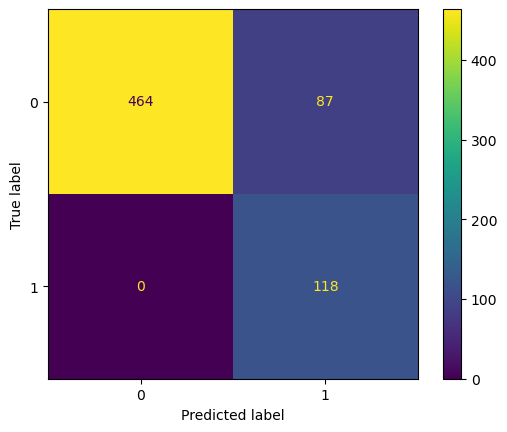

In [126]:
comp_matrix(best_rf.predict(Xi_mice_bu_df.drop(columns=['response_in_12mo'])), Xi_mice_bu_df['response_in_12mo'])

In [134]:
import shap

shap_explainers = shap.Explainer(best_rf.predict, X_train.loc[:,best_rf.feature_names_in_])
shap_values = shap_explainers(X_test.loc[:,best_rf.feature_names_in_])

PermutationExplainer explainer: 135it [01:24,  1.42it/s]                         


<Axes: xlabel='SHAP value (impact on model output)'>

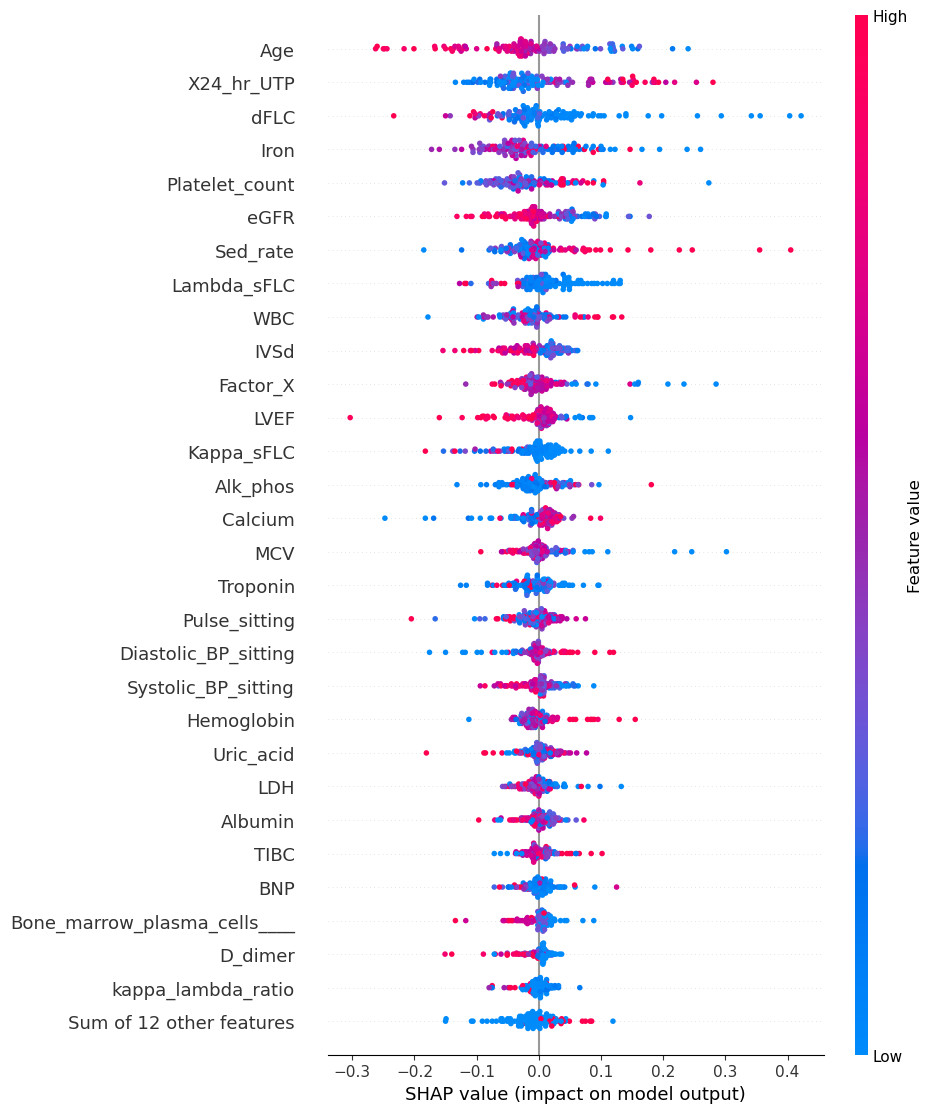

In [135]:
shap.plots.beeswarm(shap_values, show=False, max_display=30)

---

In [ ]:
#relapse_df.to_csv("data/processed/relapse_processed.tsv", sep="\t")
#comb_df.rename(columns=amyloid.ddict_clean).to_csv("data/processed/AL_with_ccp_tx_04.tsv", sep="\t")

In [ ]:
# treatments_s = treatments_df.dropna(subset=["Start date"]).sort_values("Start date").reset_index().groupby("Code ID")["treatment_group"].agg(list)
# treatments_s.name = "tx_by_date"

# first_treatment_s = treatments_df.dropna(subset=["Start date"]).sort_values("Start date").reset_index().drop_duplicates(subset="Code ID", keep="first").set_index("Code ID")["treatment_group"]
# first_treatment_s.name = "first_tx"

# all_treatments_s = treatments_df.sort_values("Start date").reset_index().groupby("Code ID")["treatment_group"].agg(list)
# all_treatments_s.name = "all_tx"

# num_treatments_s = treatments_df.sort_values("Start date").reset_index().groupby("Code ID").size()
# num_treatments_s.name = "num_tx"

In [94]:
comb_df.groupby(["cluster","first_tx"]).size().reset_index().pivot(values=0, columns="cluster", index="first_tx").fillna(0).astype(int)

cluster,1,2,3
first_tx,,,
BDR,3,0,1
Bendamustine,0,0,1
Cyclophosphamide,2,3,0
Dara-CyBorD,17,17,16
Daratumumab-based,6,4,5
Glucocorticoid monotherapy,24,27,11
HDM/SCT,144,212,64
IMiD-based,38,23,21
Melphalan-based regimen,115,161,97
